In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, roc_auc_score
import imblearn

In [ ]:
path = "/content/drive/MyDrive/datasets/diabetes with 2000 samples.csv"
data = pd.read_csv(path)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [ ]:
np.set_printoptions(threshold = sys.maxsize)

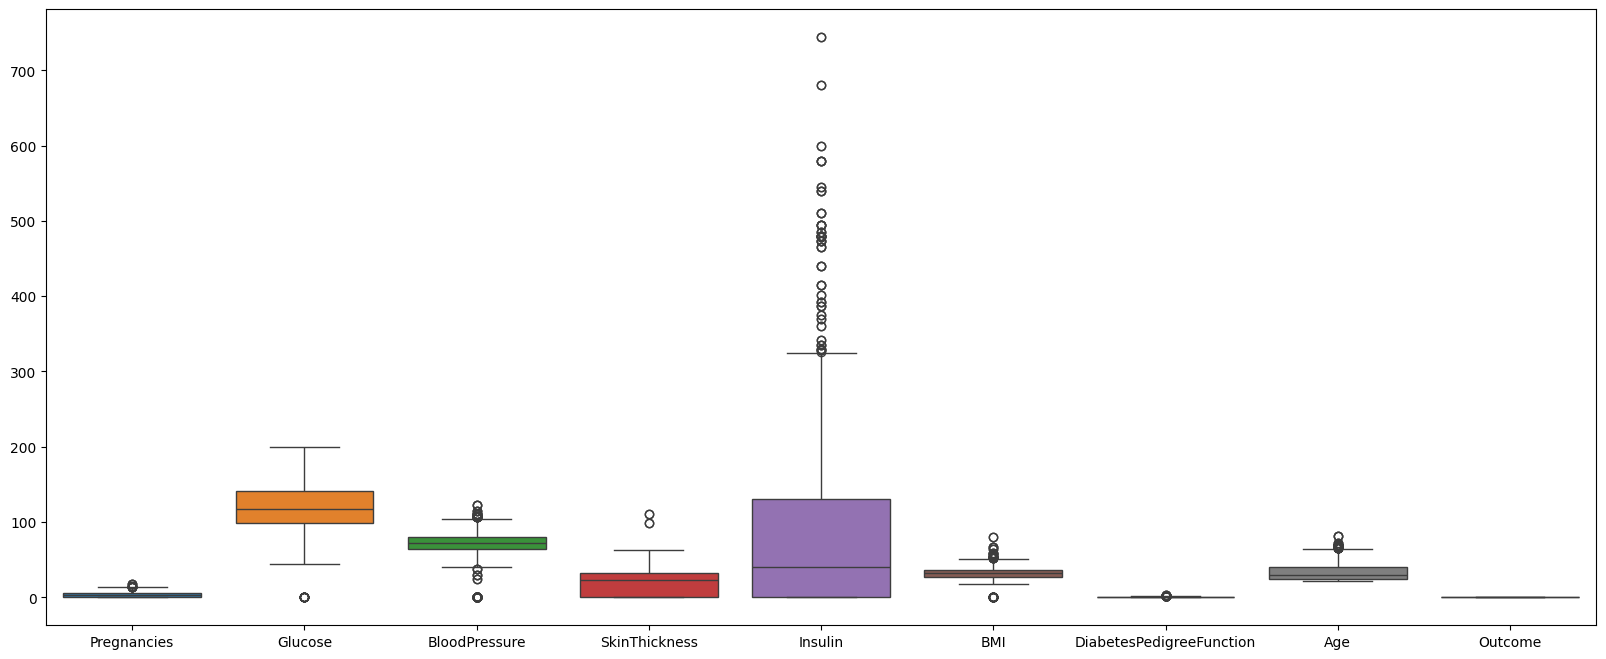

In [ ]:
plt.figure(figsize=(20, 8))
sb.boxplot(data= data)
plt.show()

In [ ]:
Q1 = data[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].quantile(0.25)
Q3 = data[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].quantile(0.75)
IQR = Q3 - Q1

outliers = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

data_without_outliers = data[~((data[outliers] < (Q1 - 1.5 * IQR)) | (data[outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]

data_without_outliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
3,0,135,68,42,250,42.3,0.365,24,1
5,0,173,78,32,265,46.5,1.159,58,0
6,4,99,72,17,0,25.6,0.294,28,0
...,...,...,...,...,...,...,...,...,...
1994,1,79,60,42,48,43.5,0.678,23,0
1995,2,75,64,24,55,29.7,0.370,33,0
1996,8,179,72,42,130,32.7,0.719,36,1
1997,6,85,78,0,0,31.2,0.382,42,0


In [ ]:
data_without_outliers = data_without_outliers.reset_index()
data_without_outliers.drop(['index'],axis = 1,inplace = True)
data_without_outliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,135,68,42,250,42.3,0.365,24,1
3,0,173,78,32,265,46.5,1.159,58,0
4,4,99,72,17,0,25.6,0.294,28,0
...,...,...,...,...,...,...,...,...,...
1647,1,79,60,42,48,43.5,0.678,23,0
1648,2,75,64,24,55,29.7,0.370,33,0
1649,8,179,72,42,130,32.7,0.719,36,1
1650,6,85,78,0,0,31.2,0.382,42,0


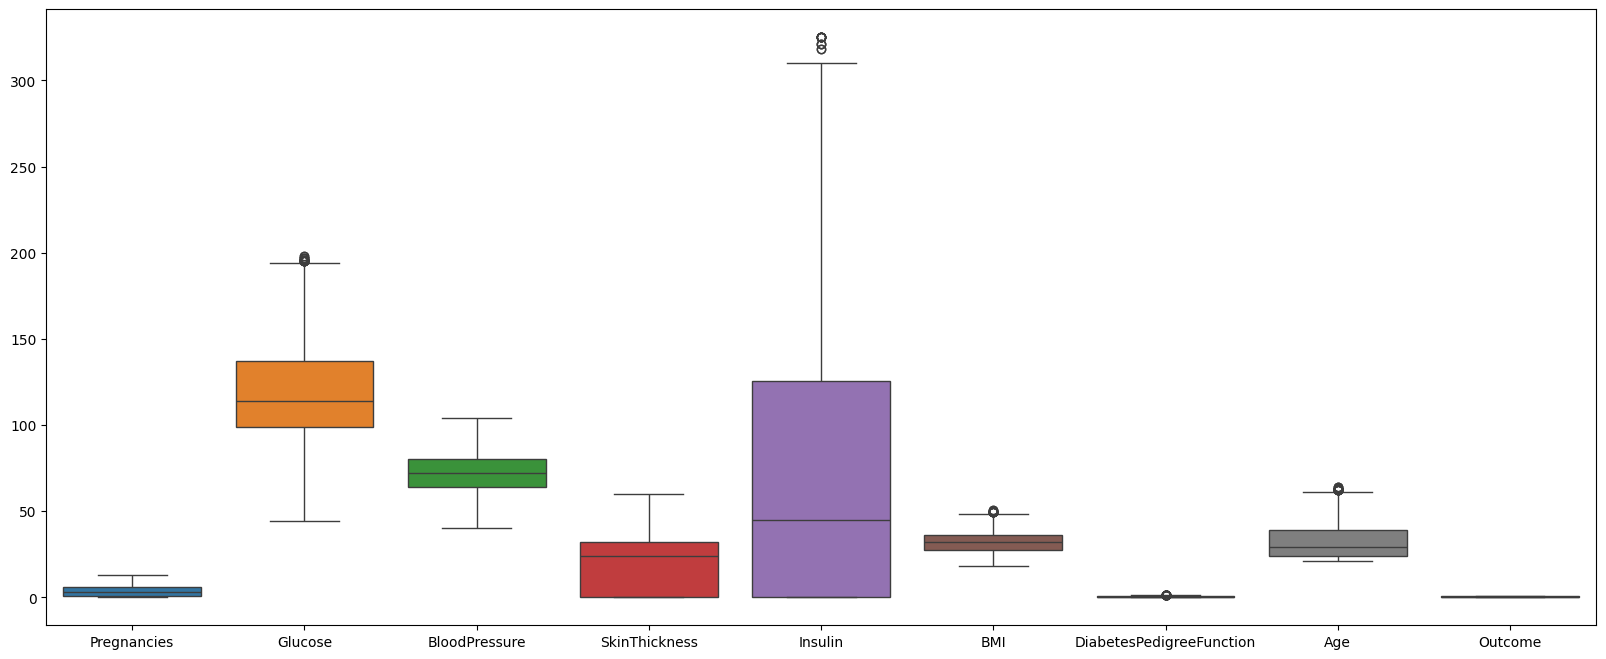

In [ ]:
plt.figure(figsize=(20, 8))
sb.boxplot(data= data_without_outliers)
plt.show()

In [ ]:
X = data_without_outliers.iloc[:,:-1]
y = data_without_outliers.iloc[:,-1]

In [ ]:
columns_to_replace = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
X[columns_to_replace] = X[columns_to_replace].replace(0,np.nan)
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2,138,62,35.0,NaN,33.6,0.127,47
1,0,84,82,31.0,125.0,38.2,0.233,23
2,0,135,68,42.0,250.0,42.3,0.365,24
3,0,173,78,32.0,265.0,46.5,1.159,58
4,4,99,72,17.0,NaN,25.6,0.294,28
...,...,...,...,...,...,...,...,...
1647,1,79,60,42.0,48.0,43.5,0.678,23
1648,2,75,64,24.0,55.0,29.7,0.370,33
1649,8,179,72,42.0,130.0,32.7,0.719,36
1650,6,85,78,NaN,NaN,31.2,0.382,42


In [ ]:
imputer = KNNImputer(n_neighbors=3)
X = imputer.fit_transform(X)
X

array([[2.00000000e+00, 1.38000000e+02, 6.20000000e+01, 3.50000000e+01,
        1.40000000e+02, 3.36000000e+01, 1.27000000e-01, 4.70000000e+01],
       [0.00000000e+00, 8.40000000e+01, 8.20000000e+01, 3.10000000e+01,
        1.25000000e+02, 3.82000000e+01, 2.33000000e-01, 2.30000000e+01],
       [0.00000000e+00, 1.35000000e+02, 6.80000000e+01, 4.20000000e+01,
        2.50000000e+02, 4.23000000e+01, 3.65000000e-01, 2.40000000e+01],
       [0.00000000e+00, 1.73000000e+02, 7.80000000e+01, 3.20000000e+01,
        2.65000000e+02, 4.65000000e+01, 1.15900000e+00, 5.80000000e+01],
       [4.00000000e+00, 9.90000000e+01, 7.20000000e+01, 1.70000000e+01,
        7.00000000e+01, 2.56000000e+01, 2.94000000e-01, 2.80000000e+01],
       [2.00000000e+00, 8.30000000e+01, 6.50000000e+01, 2.80000000e+01,
        6.60000000e+01, 3.68000000e+01, 6.29000000e-01, 2.40000000e+01],
       [2.00000000e+00, 8.90000000e+01, 9.00000000e+01, 3.00000000e+01,
        1.80000000e+02, 3.35000000e+01, 2.92000000e-01, 4.

In [ ]:
X_df = pd.DataFrame(X,columns=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])
X_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.0,138.0,62.0,35.000000,140.000000,33.6,0.127,47.0
1,0.0,84.0,82.0,31.000000,125.000000,38.2,0.233,23.0
2,0.0,135.0,68.0,42.000000,250.000000,42.3,0.365,24.0
3,0.0,173.0,78.0,32.000000,265.000000,46.5,1.159,58.0
4,4.0,99.0,72.0,17.000000,70.000000,25.6,0.294,28.0
...,...,...,...,...,...,...,...,...
1647,1.0,79.0,60.0,42.000000,48.000000,43.5,0.678,23.0
1648,2.0,75.0,64.0,24.000000,55.000000,29.7,0.370,33.0
1649,8.0,179.0,72.0,42.000000,130.000000,32.7,0.719,36.0
1650,6.0,85.0,78.0,27.333333,75.666667,31.2,0.382,42.0


In [ ]:
new_data = pd.concat([X_df,y],axis = 1)
new_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2.0,138.0,62.0,35.000000,140.000000,33.6,0.127,47.0,1
1,0.0,84.0,82.0,31.000000,125.000000,38.2,0.233,23.0,0
2,0.0,135.0,68.0,42.000000,250.000000,42.3,0.365,24.0,1
3,0.0,173.0,78.0,32.000000,265.000000,46.5,1.159,58.0,0
4,4.0,99.0,72.0,17.000000,70.000000,25.6,0.294,28.0,0
...,...,...,...,...,...,...,...,...,...
1647,1.0,79.0,60.0,42.000000,48.000000,43.5,0.678,23.0,0
1648,2.0,75.0,64.0,24.000000,55.000000,29.7,0.370,33.0,0
1649,8.0,179.0,72.0,42.000000,130.000000,32.7,0.719,36.0,1
1650,6.0,85.0,78.0,27.333333,75.666667,31.2,0.382,42.0,0


In [ ]:
X = new_data.iloc[:,:-1].values
y = new_data.iloc[:,-1]

In [ ]:
ss = StandardScaler()
X = ss.fit_transform(X)

In [ ]:
X_df = pd.DataFrame(X,columns=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])
X_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.516987,0.643549,-0.900648,0.643713,0.149606,0.231347,-1.207742,1.378275
1,-1.145898,-1.209812,0.921160,0.230683,-0.069792,0.944178,-0.793662,-0.875162
2,-1.145898,0.540585,-0.354106,1.366514,1.758520,1.579527,-0.278015,-0.781269
3,-1.145898,1.844802,0.556798,0.333941,1.977918,2.230372,2.823678,2.411100
4,0.111925,-0.694990,0.010256,-1.214920,-0.874249,-1.008358,-0.555371,-0.405696
...,...,...,...,...,...,...,...,...
1647,-0.831442,-1.381420,-1.082829,1.366514,-1.196032,1.765483,0.944693,-0.875162
1648,-0.516987,-1.518706,-0.718467,-0.492119,-1.093646,-0.373009,-0.258483,0.063770
1649,1.369748,2.050731,0.010256,1.366514,0.003341,0.091880,1.104856,0.345450
1650,0.740836,-1.175491,0.556798,-0.147927,-0.791365,-0.140564,-0.211606,0.908809


In [ ]:
Kernel_PCA = KernelPCA(n_components=4,random_state=42)
data_pca = Kernel_PCA.fit_transform(X_df)
data_pca

array([[ 6.01654487e-01,  5.78035255e-02, -3.67434035e-01,
        -1.24107699e+00],
       [-4.23313297e-01, -1.26075875e+00,  1.37736218e+00,
        -8.76039844e-01],
       [ 1.33443893e+00, -2.67337503e+00, -4.55212867e-02,
        -6.23262948e-01],
       [ 3.63453125e+00, -1.33215872e+00, -1.07345378e+00,
         2.47750572e+00],
       [-1.70893637e+00,  9.01004129e-01, -8.24371390e-02,
        -2.98736550e-01],
       [-1.16590255e+00, -7.32068024e-01,  1.34708137e+00,
         8.89403060e-01],
       [ 7.51678932e-01,  1.95425629e-01,  6.33416900e-01,
        -6.79291573e-01],
       [-3.09488806e-01,  2.10563953e-01,  1.16991138e+00,
        -1.13014614e+00],
       [ 8.91136193e-02,  9.03968504e-01, -8.14322549e-01,
         2.90791302e+00],
       [-9.25676196e-01,  7.18031391e-01, -2.41977837e-01,
        -4.29962546e-01],
       [-1.89333676e+00,  8.50290413e-02,  4.14698969e-01,
         7.02061798e-01],
       [ 1.76868931e+00,  1.85911691e+00, -1.97948186e+00,
      

In [ ]:
final_data = pd.DataFrame(data_pca,columns=['Feature_1','Feature_2','Feature_3','Feature_4'])
final_data = pd.concat([final_data,y],axis = 1)
final_data

,Feature_1,Feature_2,Feature_3,Feature_4,Outcome
0,0.601654,0.057804,-0.367434,-1.241077,1
1,-0.423313,-1.260759,1.377362,-0.876040,0
2,1.334439,-2.673375,-0.045521,-0.623263,1
3,3.634531,-1.332159,-1.073454,2.477506,0
4,-1.708936,0.901004,-0.082437,-0.298737,0
...,...,...,...,...,...
1647,-0.553867,-1.671019,2.518651,0.925516,0
1648,-1.775076,0.390360,0.888011,0.000081,0
1649,2.049475,0.407314,-0.486110,0.840052,1
1650,-0.160934,1.489150,1.071542,-0.061987,0


In [ ]:
X_data = final_data.iloc[:,:-1]
y_data = final_data.iloc[:,-1]

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X_data,y_data,test_size=0.25,random_state = 42)

In [ ]:
print(np.unique(y_train,return_counts = True))

(array([0, 1]), array([863, 376]))


In [ ]:
ros = RandomOverSampler(random_state=42)

In [ ]:
X_train_ros , y_train_ros = ros.fit_resample(X_train,y_train)

In [ ]:
print(np.unique(y_train_ros,return_counts = True))

(array([0, 1]), array([863, 863]))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=15,random_state=42)

In [ ]:
dt = dt.fit(X_train_ros,y_train_ros)

In [ ]:
y_predict_train = dt.predict(X_train_ros)

In [ ]:
print(classification_report(y_true = y_train_ros,y_pred = y_predict_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       863

    accuracy                           1.00      1726
   macro avg       1.00      1.00      1.00      1726
weighted avg       1.00      1.00      1.00      1726



In [ ]:
print(accuracy_score(y_train_ros,y_predict_train))

1.0


In [ ]:
print(confusion_matrix(y_train_ros,y_predict_train))

[[863   0]
 [  0 863]]


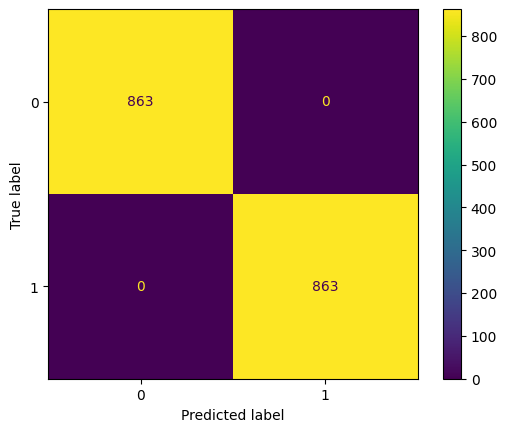

In [ ]:
confusion_matrix_train = confusion_matrix(y_train_ros,y_predict_train)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [ ]:
y_predict_test = dt.predict(X_test)

In [ ]:
print(classification_report(y_test,y_predict_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       273
           1       0.99      0.94      0.96       140

    accuracy                           0.98       413
   macro avg       0.98      0.97      0.97       413
weighted avg       0.98      0.98      0.98       413



In [ ]:
print(accuracy_score(y_test,y_predict_test))

0.9757869249394673


In [ ]:
print(confusion_matrix(y_test,y_predict_test))

[[272   1]
 [  9 131]]


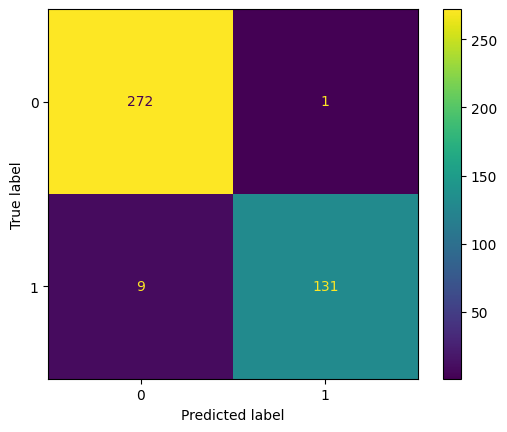

In [ ]:
confusion_matrix_test = confusion_matrix(y_test,y_predict_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [ ]:
y_pred_prob = dt.predict_proba(X_test)[:,1]
fpr , tpr , threshold = roc_curve(y_test,y_pred_prob)

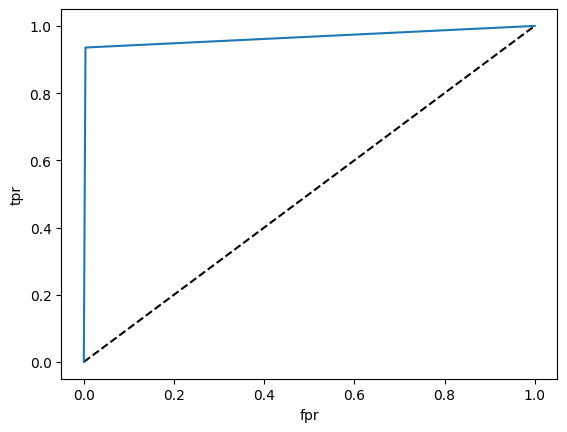

In [ ]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [ ]:
roc_auc_score(y_test,y_pred_prob)

0.966025641025641

In [ ]:
k_folds = KFold(n_splits=5)
cv_scores = cross_val_score(dt,X_train_ros,y_train_ros, cv = k_folds)

In [ ]:
summ = 0
for i in range(0,len(cv_scores)):
  summ += cv_scores[i]
print(f"mean accuracy is {round(summ / len(cv_scores),3)}")

mean accuracy is 0.961
